# Writing a new data loader

One of the goals of this library is to make it easy to import/export data to and from different simulation codes. This example demonstrates how you would write a new data loader to read in data.
DataLoaders must inhereit from the `ParticlePhaseSpace.DataLoaders._DataImportersBase` class. They must in addition provide two methods:

1. `_check_input_data`: In this method you should check that whatever data the user has supplied is what your DataLoader is expecting. For example: is it a file? Is the extension correct? etc. Basically this is a pre-check for some basic error handling.
2. `__import_data`: this is where the data actually gets imported. The fundamental goal of this method is to populate the data frame attribute stored at DataLoader.data such that it contains the [required columns](). If it does this succesfully, then it is guaranteed that the data can now be loaded into a PhaseSpace instance.

For the purposes of demonstration, I am going to develop a new DataLoader which reads in some data I received from  a colleague. This data is ASCII encoded (i.e. text file) and contains the following columns:

```
x (mm)	y (mm)	z (mm)	px (MeV/c)	py (MeV/c)	pz (MeV/c)	E (MeV)
```

Note that this data already contains all the columns we need, and with the correct units, so reading it in should be pretty straight forward. Note also that this format does not include the type of particle. This means that users will have to specify particle type using the `particle_type=` input.
The basic format of any new data loader looks like this:

In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from ParticlePhaseSpace.DataLoaders import _DataImportersBase
import numpy as np
import ParticlePhaseSpace.__particle_config__ as particle_cfg

class NewDataLoader(_DataImportersBase):

    def _import_data(self):
        pass

    def _check_input_data(self):
        pass

Now, our job is to fill in these two methods. Note that both of these will be called automatically; in addition the data entered by the user will be available at `self._input_data`. Below is an example of the complete data loader:

In [2]:
class NewDataLoader(_DataImportersBase):

    def _import_data(self):
        Data = np.loadtxt(self._input_data, skiprows=1)
        self.data['x [mm]'] = Data[:, 0]
        self.data['y [mm]'] = Data[:, 1]
        self.data['z [mm]'] = Data[:, 2]
        self.data['px [MeV/c]'] = Data[:, 3]
        self.data['py [MeV/c]'] = Data[:, 4]
        self.data['pz [MeV/c]'] = Data[:, 5]
        self.data['particle type [pdg_code]'] = particle_cfg.particle_properties[self._particle_type]['name']
        # we also need to fill in weight, particle id, and time; since none of these are specified we just use all
        # ones for weight, 1,2,3... for particle id, and all zeros for time:
        self.data['weight'] = np.ones(Data.shape[0])
        self.data['particle id'] = np.arange(len(self.data))

        self.data['time [ps]'] = 0  # may want to replace with time feature if available?

        # because we have momentum and energy, we can double check that our momentum to energy conversion is 
        # consisten with the values in the phase space:
        E = Data[:, 6]
        self._check_energy_consistency(Ek=E)

    def _check_input_data(self):
        # is the input a file?
        if not Path(self._input_data).is_file():
            raise FileNotFoundError(f'input data file {self._import_data()} does not exist')
        # does it have the right extension?
        if not Path(self._input_data).suffix == '.dat':
            raise Exception('This data loaders requires a *.dat file')
        # the header is on the first line; does it look correct?
        with open(self._input_data) as f:
            first_line = f.readline()
            if not first_line == 'x (mm)\ty (mm)\tz (mm)\tpx (MeV/c)\tpy (MeV/c)\tpz (MeV/c)\tE (MeV)\n':
                raise Exception('file header does not look correct')
        if not self._particle_type:
            raise Exception('this data loader requires particle_type to be specified')

OK, now lets check out if this works:

generating weighted scatter plot...can be slow...
down sampling scatter plot data by factor of 1.0


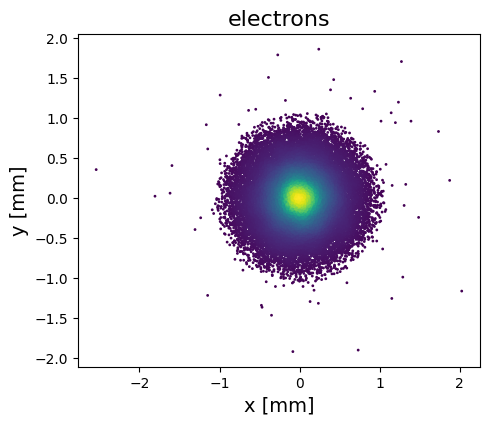

In [4]:
from ParticlePhaseSpace._ParticlePhaseSpace import PhaseSpace

data_loc  = Path(r'../tests/test_data/new_data_loader_demo.dat').absolute()
data = NewDataLoader(data_loc, particle_type='electrons')

PS = PhaseSpace(data)
PS.plot_particle_positions(weight_position_plot=True, beam_direction='z')